Back in 2020, when the pandemic started, I was stuck inside. I figured I might as well take the time to learn something new and build my first PC. I assembled everything and turned it on and everything was great. Until it randomly...shut off? Then started up again. Like it had been randomly reset. Weird, I thought. I better check my connections. Everythign was snug and correctly configured in the BIOS. Everything was eluding my problem solving capabilities, until I was able to collect hardware sensory data about my computer.

Using HWInfo64, I was able to log values all the way from chassis intrusion to VDD and all core voltages/frequencies as well as voltage rails and their deviations. I had lots and lots of data, might as well learn something with it? Explore it a bit and see if I can't figure out what was wrong, maybe it was hiding in the data.

To discover some underlying trend that I am not privvy to, I should choose how to model the data carefully. Thus my searching began for how to model anomaly detection, a fairly decent start I would say. Multiple suggestions on algorithms came up, including XGBoost, LSTM, RNN, and VAE's. Initally, I had planned on using an XGBoost instence to help uncover some problems, however further exploration with an XGBoost required me to have a label set to accompany my training data. Of which, I did not know what to label as noraml vs what to label as test and test labels. So I needed something semi-superivsed at best, but unsuperivsed turned out to be easier to tackle slightly. There can be further improvements to my exploration/model, however I find this to be a fun first-dip into the mysterious data I have collected.

In [1]:
import math
import re
import sys
import os
import random
import numpy as np
import pandas as pd
import multiprocessing
import seaborn as sns
import matplotlib.pyplot as plt

Typical imports, I needed the regex library to find some columns that needed some editing for pandas to be happy.

In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, BatchNormalization
from tensorflow.keras.losses import mse, kl_divergence
from tensorflow.keras.optimizers import Adam
#print(os.path.abspath(tf.keras.optimizers.__file__))
from tensorflow.keras import backend as K

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

2023-01-13 17:16:33.237796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


These imports are a bit different. I needed to disable eager execution because I am new to TensorFlow as well as working off of WSL2 in a windows env, which has caused some issues with CPU only packages being installed from conda, and not being able to use my GPU withough the many Hyper-V's in place between my WSL2 20.04 distro and my actual Nvidia hardware.

First function I'm going to want to create is a seeding function so that I can create reproducible results, reguardless of how varied the anomaly data is.

In [3]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

In [4]:
set_seed(1234)

Let's load in the data now.

In [5]:
def preprocess_data():
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)

    df1 = pd.read_csv('/home/cdrazic/projects/Projects/vae/crash1.csv')
    df2 = pd.read_csv('/home/cdrazic/projects/Projects/vae/crash2.csv')

    df_col_names = ['Thermal Throttling (HTC) [Yes/No]', 
    'Thermal Throttling (PROCHOT CPU) [Yes/No]',
    'Thermal Throttling (PROCHOT EXT) [Yes/No]', 
    'Drive Failure [Yes/No]',
    'Drive Warning [Yes/No]',
    'Performance Limit - Power [Yes/No]',
    'Performance Limit - Thermal [Yes/No]',
    'Performance Limit - Reliability Voltage [Yes/No]',
    'Performance Limit - Max Operating Voltage [Yes/No]',
    'Performance Limit - Utilization [Yes/No]', 
    'Performance Limit - SLI GPUBoost Sync [Yes/No]']

    df1 = df1.drop(columns=['Date','Time'])

    df1[df_col_names] = df1[df_col_names].astype(bool)

    df1.columns = [
        regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df1.columns.values
        ]

    df2 = df2.drop(columns=['Date','Time'])

    df2[df_col_names] = df2[df_col_names].astype(bool)

    df2.columns = [
        regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df2.columns.values
        ]

    df2 = df2.loc[:,df2.columns.intersection(df1.columns)]
    df1 = df1.loc[:,df1.columns.intersection(df2.columns)]

    return df2, df1

Here is where the regex neds to be placed, as '[', ']' and '<' weren't playing nicely with dataframes, so it's just easier for me to subsititute them for underscores. Finally, since there are 2 CSV's, and I know specifically there were some column difference between the two, I took the intersection of the two, to allow for similarly shaped datafraems to come out on the otherside.

We should probably split up the data into training and test data.

In [6]:
def split_data(df1, df2):
    train_len = int(0.8 * len(df2))
    x_train = df2[:train_len]
    
    x_test_norm = df2[train_len:]

    test_len = int(0.2 * len(x_test_norm))
    x_test_attk = df1[:test_len]

    x_test = np.concatenate([x_test_norm, x_test_attk])

    return x_train, x_test

I lean towards the classic 80/20 split for train and test. In this case I know specifically that df1, or crash1.csv there was an actual carsh that happened while recording the values, hence why I am using df1 as my "test" in this scenario. I want to pull some of the training set into test (data leakage I am aware of), to have half normal data and half what I assume as anomaly data.

Alright, lets finally get around to seeing what some of this data looks like through some PCA, and how the distribution of variance lands.

In [7]:
def feature_representation(X):
    scaler = StandardScaler()
    x_x = np.reshape(X, (X.shape[0], -1))
    scaler.fit(x_x)
    X_scaled = scaler.transform(x_x)
    all_PCA = PCA(n_components=x_x.shape[1], random_state=1993)
    all_PCA.fit(X_scaled)
    X_all_PCA = all_PCA.transform(X_scaled)
    variance_ratio = np.cumsum(all_PCA.explained_variance_ratio_ * 100)

    plt.plot(variance_ratio)
    plt.xlabel('# of components')
    plt.ylabel('explained variance')
    plt.grid()
    plt.show()

In [8]:
_norm_, _attk_ = preprocess_data()

In [9]:
x_train, x_test = split_data(_attk_, _norm_)

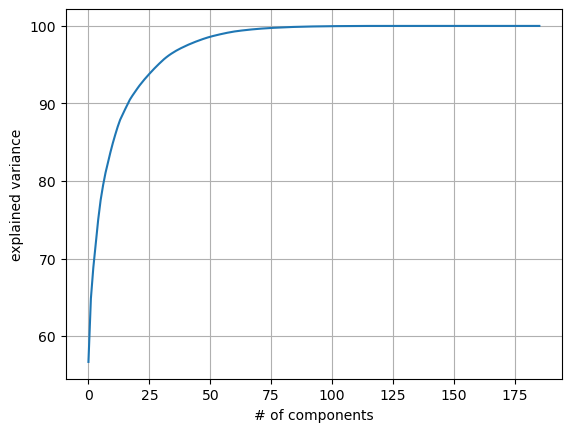

In [10]:
feature_representation(x_train)

Ah, now we can see that about 50 of the first components carry about 95% of the explained variance. I could use this as a quick dimensionaility reduction, but for now I'm going to keep it the way it is.

Let's scale the train and test set so that the model learns a bit easier.

In [11]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [12]:
og_dim = x_train.shape[1]
input_shape = (og_dim,)

Now I'm going to see what I can do about generating an aribitrary amount of layers should I want to explore more or less layers in the future.

In [13]:
def generate_layer_shape(og_dim, scaler, x):
    return [int(og_dim*scaler/i) for i in range(2, x)]

In [14]:
num_layers = 10
scale = 2

inner_layers = generate_layer_shape(og_dim, scale, num_layers)
latent_dim = inner_layers[-1] - int(inner_layers[-1]/(num_layers))

Finally, lets define the VAE model.

In [15]:
def encode_decode_network(og_dim, input_shape, inner_layer_shape, latent_dim):
    #encoder
    inputs = Input(shape=input_shape, name='encoder_in')

    #hidden states
    #[93, 62, 46, 37, 31, 26, 23, 20]
    x = Dense(inner_layer_shape[0], activation='relu')(inputs)
    x = BatchNormalization(axis=-1, trainable=False)(x)
    x = Dense(inner_layer_shape[7], activation='relu')(x)

    #latent dim
    #[...,18]
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    #reparamtrick
    z = Lambda(sample_method, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    #encoder model
    encoder = Model(inputs, z, name='encoder')

    # #decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sample')

    #hidden states
    #opposite of above
    x = Dense(inner_layer_shape[7], activation='relu')(latent_inputs)
    x = BatchNormalization(axis=-1, trainable=False)(x)
    x = Dense(inner_layer_shape[0], activation='relu')(x)

    #decode out
    outputs = Dense(og_dim, activation='sigmoid')(x)
    
    #decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    outputs = decoder(encoder(inputs))
    vae_model = Model(inputs, outputs, name='vae')

    return vae_model, encoder, decoder, x, z_mean, z_log_var

We'll probably need the reparam trick to get z_mean and z_log_var out and properly trainable.

In [16]:
def sample_method(args):
    z_mean, z_log_var = args
    return z_mean + K.exp(0.5 * z_log_var) * K.random_normal(
        shape=(K.shape(z_mean)[0],K.int_shape(z_mean)[1]))

As I am returning alot of items from the VAE model build function for future analysis and metric calculations, let's set up those return values.

In [17]:
vae_model, encoder, decoder, x, z_mean, z_log_var  = encode_decode_network(
        og_dim, input_shape, inner_layers, latent_dim)

Viewing the model summary gives us this:

In [18]:
vae_model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_in (InputLayer)     [(None, 186)]             0         
                                                                 
 encoder (Functional)        (None, 37)                46301     
                                                                 
 decoder (Functional)        (None, 186)               44316     
                                                                 
Total params: 90,617
Trainable params: 89,709
Non-trainable params: 908
_________________________________________________________________


90k params, not too bad. Shouldn't need to make an enormously large model for this I am assuming, hence the ability to play around with layers and their sizes in the future!

For a VAE, we need a reconstruction loss as well as the KL-divergence loss, essentially calculating the distance between two distributions. In this case, original distribution and reconstructed distributions.

In [19]:
def vae_kl_loss(x, x_decode_mean):
    recon_loss = K.sum(K.square(x - x_decode_mean))

    kl_loss = -0.5 * K.sum(
        1 + z_log_var - K.square(z_mean)- K.square(K.exp(z_log_var)), axis=-1
        )

    return K.mean(recon_loss + kl_loss)

Finally, lets compile the model for a standard training fit, as I don't believe my data to be complicated enough to warrant a custom loader or training loop...yet.

In [20]:
def optim(lr, clip_val, ams_grad):
    return tf.keras.optimizers.Adam(
        learning_rate=lr,
        clipvalue=clip_val,
        amsgrad=ams_grad,
        )

In [21]:
    vae_model.compile(
        optimizer=optim(lr=0.0001, clip_val=0.5, ams_grad=True),
        loss=vae_kl_loss
        )

Lets fit the model to the data, hopefully it goes well! I like to throw in an early stopping callback just in case, don't need to overfit the model.

In [22]:
def early_stopping(monitor_func, epochs_to_wait, mindelta):
    return tf.keras.callbacks.EarlyStopping(
        monitor=monitor_func,
        patience=epochs_to_wait,
        min_delta=mindelta
        )

In [23]:
vae_model.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=16,
    batch_size=16,
    callbacks=[early_stopping(monitor_func='loss', epochs_to_wait=10, mindelta=0.001)]
    )

Train on 77646 samples
Epoch 1/16
   16/77646 [..............................] - ETA: 14:49 - loss: 529.1526

2023-01-13 17:17:29.187550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 17:17:29.206131: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-01-13 17:17:29.234896: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/dense_4/kernel/v/Assign' id:792 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_4/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_4/kernel/v, training/Adam/dense_4/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigg

77646/77646 [==============================] - 5s 62us/sample - loss: 57.6597
Epoch 2/16
77646/77646 [==============================] - 5s 60us/sample - loss: 29.0809
Epoch 3/16
77646/77646 [==============================] - 5s 59us/sample - loss: 25.7134
Epoch 4/16
77646/77646 [==============================] - 5s 60us/sample - loss: 23.6023
Epoch 5/16
77646/77646 [==============================] - 5s 60us/sample - loss: 22.0751
Epoch 6/16
77646/77646 [==============================] - 5s 59us/sample - loss: 20.8548
Epoch 7/16
77646/77646 [==============================] - 5s 60us/sample - loss: 19.8146
Epoch 8/16
77646/77646 [==============================] - 5s 59us/sample - loss: 19.0508
Epoch 9/16
77646/77646 [==============================] - 5s 59us/sample - loss: 18.5504
Epoch 10/16
77646/77646 [==============================] - 5s 60us/sample - loss: 18.1261
Epoch 11/16
77646/77646 [==============================] - 5s 60us/sample - loss: 17.8722
Epoch 12/16
77646/77646 [=====

Predicting how well the model did on train, we get this:

In [24]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y) ** 2, axis=1))

x_train_pred = vae_model.predict(x_train)

rmse_train = rmse(x_train_pred, x_train)
e_train = np.quantile(rmse_train, 0.99)
print(f'Avg train error {np.mean(rmse_train)}')
print(f'median train error {np.median(rmse_train)}')
print(f'99Q train: {e_train}')

/home/cdrazic/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-13 17:18:48.362062: W tensorflow/c/c_api.cc:291] Operation '{name:'decoder/dense_4/Sigmoid' id:326 op device:{requested: '', assigned: ''} def:{{{node decoder/dense_4/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/dense_4/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Avg train error 0.06223460023913155
median train error 0.05681540947092685
99Q train: 0.15099049987376165


Assuming that train was mostly df2, or the normal CSV file, should values exceed the 99th quantile, or some other quantile, I haven't figured a good thershold for it, but lets stick with 99th quantile.

In [25]:
x_test_pred = vae_model.predict(x_test)
anom = (rmse_train > e_train)

In [26]:
rmse_res_test = rmse(x_test_pred, x_test)
anom_test = (rmse_res_test > np.quantile(rmse_res_test, 0.99))

I want to take a look at what the latent vector is coming up with, as it can give me a good amount of insight as to what the reconstruction error is and what the distribution looks like. Do I have alot of small errors and a couple large ones bringing up the average? Let's find out.

In [27]:
def recon_vis(encoder, X, vec, _s):
    x_pred = encoder.predict(X)

    x_pca_transform = PCA(n_components=2).fit_transform(x_pred)
    plt.figure(figsize=(12,10))
    sns.scatterplot(x=x_pca_transform[:, 0], y=x_pca_transform[:, 1], s=_s, hue=vec)
    plt.grid()
    plt.show()

2023-01-13 17:18:56.304412: W tensorflow/c/c_api.cc:291] Operation '{name:'z/add' id:147 op device:{requested: '', assigned: ''} def:{{{node z/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](z_mean/BiasAdd, z/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


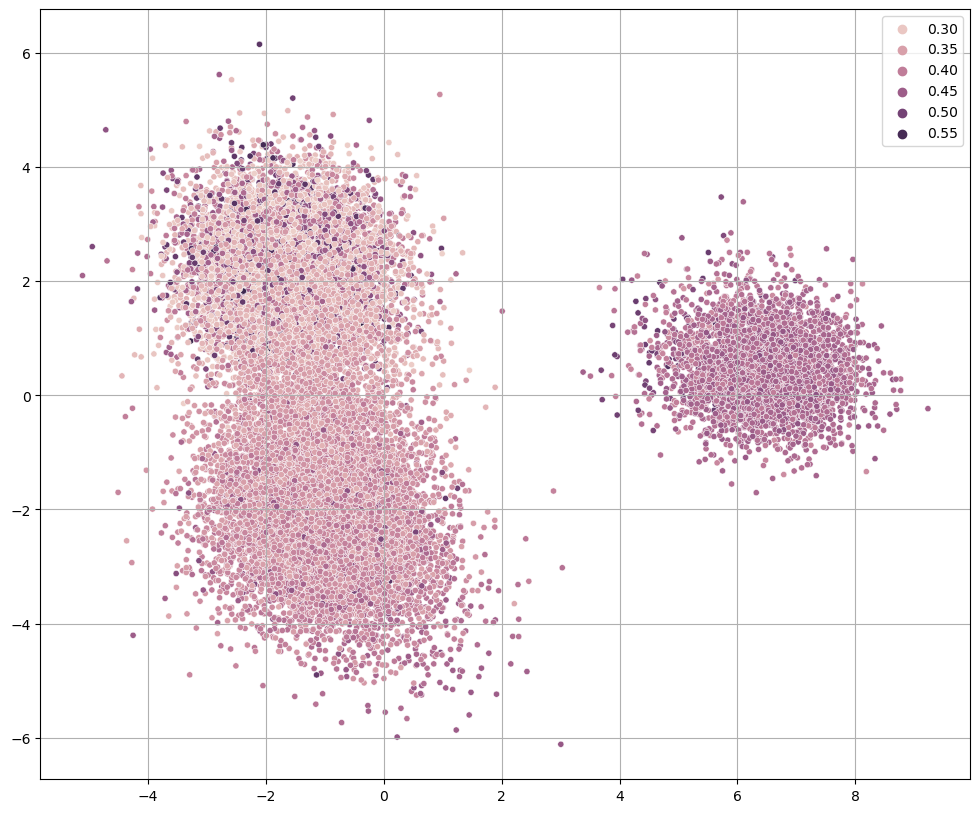

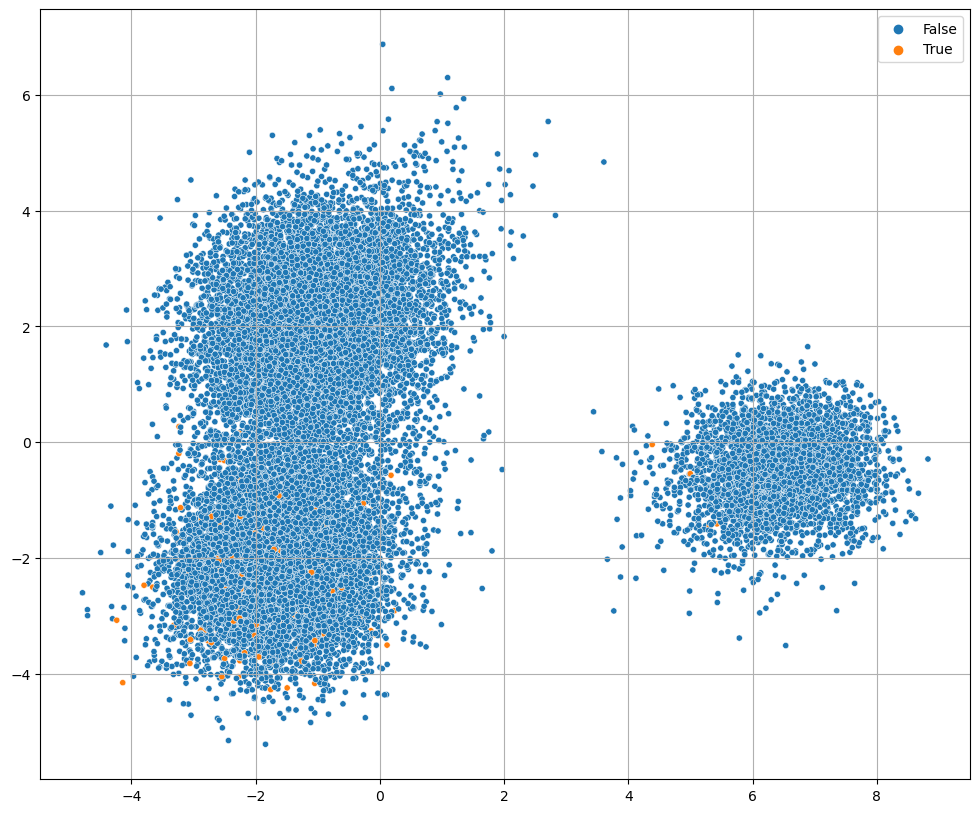

In [28]:
recon_vis(encoder, x_test, rmse_res_test, 20)
recon_vis(encoder, x_test, anom_test, 20)

Interesting, the majority of the latent vectors coming out of the encoder seem to be not too bad, sans the very few outliers. No pun inteneded...

As for thresholding the test set on the quantile, I would expect more True datapoints than what I am seeing. The threshold is definitely something I can tune.

In [29]:
print(mean_squared_error(x_test, x_test_pred))
print(r2_score(x_test, x_test_pred))

0.14884186833986196
-56.96650835672883


If the MSE is around 0.14, thats not too bad, knowing that I do not know several key points about the dataset.

The more interesting score here is the R2_score, for those who need a quick refresher, the R2_score is perfect for a regression type of proglem, as I am not classifiying anything here. I chose to use R2_score because straight from sklearn.metrics, "Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)".

I am guessing that my model isn't entirely fitting or understanding what it needs to, which maybe those first 50 components need to be used, instead of the sparse nature of the rest of the dataset.

In conclusion: I already knew the answer. I had reset everything back to the default settings in the BIOS, which included XMP, I started enabling things one by one and stressing my system, and found out it was a slightly unstable XMP profile. I can manually tune alot of things in a computer, but RAM timings are not one of them. This was a fun exercise in learning more about TensorFlow, PCA and Keras, as I have never used them before!

Turns out heuristics can be a more important and potent factor than just machine learning alone, this is why domaine expertise and feature selection is of prime importance. Maybe my inital logging software didn't have the sensors for DRAM voltage or timings and command rate, nor should have I been logging the sensory data on the same machine prone to mysteriously restarting (and corrupting my logging data).

In any case, thank you for taking the time to follow my exploration into my own data, and maybe in teh future I can return to this project and fine tune it abit more with more data collected, now that my computer has not restarted in a while!